In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import numpy as np
import matplotlib.pyplot as plt


LOG.propagate = False

In [4]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-05-02 15:02:33,365 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:b4:69:26:3c
2023-05-02 15:02:35,856 | INFO     |: Connected to c0:83:b4:69:26:3c


In [5]:
# DRIVE AT WALL
incoming_data = []
time = []
distance = []
speed = []
data = []
def wall_drive(uiud, byte_arr):
    # variables
    global incoming_data
    global data
    global time
    global distance
    global speed
    
    # handle incoming data
    incoming_data = ble.bytearray_to_string(byte_arr)
    data.append(incoming_data)
    
    #indexes
    time_start = incoming_data.index('T')+2
    time_end = incoming_data.index('S')-1
    speed_start = time_end + 3
    speed_end = incoming_data.index('D')-1
    distance_start = speed_end + 3
    
    # create new arrays
    time.append(float(incoming_data[time_start:time_end]))
    speed.append(float(incoming_data[speed_start:speed_end]))
    distance.append(float(incoming_data[distance_start:]))
    

   
ble.start_notify(ble.uuid['RX_STRING'], wall_drive)
ble.send_command(CMD.DRIVE_AT_WALL, "")



2023-05-02 15:03:53,135 | INFO     |: Disconnected from 1EC8978F-60BE-444F-8CEC-1E86F5092CAA


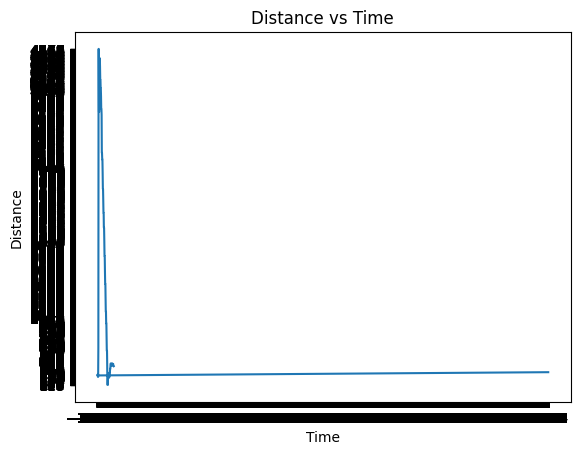

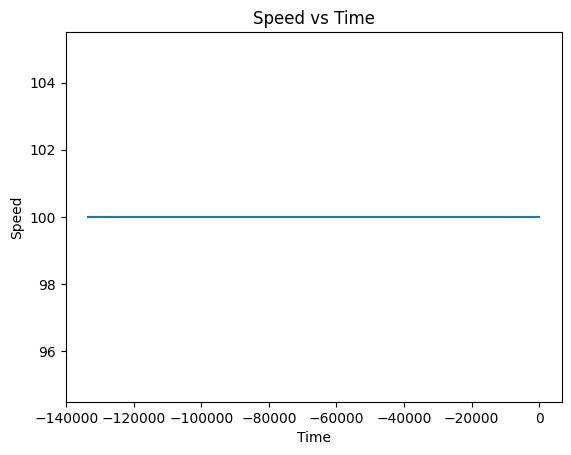

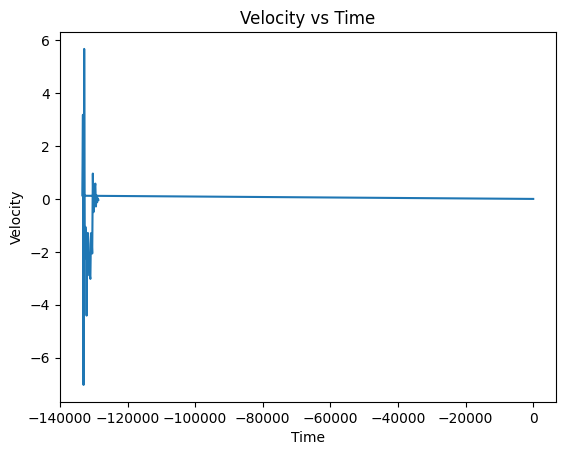

Exception: Not connected to a BLE device

In [140]:
#PLOT DATA

# Scale distances down
first = time[0]
for idx in range(len(time)):
        time[idx] = time[idx] - first
        
# Make velocity data
velocity = [0]
velocity_time = [0]
smooth = 0
for idx in range(len(time)):
    if(idx > 0 and smooth == 3):
        velocity.append((distance[idx] - distance[idx-2]) / (time[idx] - time[idx - 2])) 
        velocity_time.append(time[idx])
        smooth = 0
    smooth += 1

# print(time)
# print(distance)
# print(velocity)

plt.autoscale(enable=True, axis='both', tight=None)

#Distance 
plt.plot (time[0:], distance[0:])
plt.xticks(np.arange(min(time), max(time)))
plt.yticks(np.arange(min(distance), max(distance)))

plt.title ('Distance vs Time')
plt.xlabel ('Time')
plt.ylabel ('Distance')
plt.show()

# Speed
plt.plot (time [0:], speed [0:])

plt.title ('Speed vs Time')
plt.xlabel ('Time')
plt.ylabel ('Speed')
plt.show()

# Velocity
plt.plot (velocity_time [0:], velocity [0:])
plt.title ('Velocity vs Time')
plt.xlabel ('Time')
plt.ylabel ('Velocity')
plt.show()


ble.stop_notify(ble.uuid['RX_STRING'])




In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.disconnect()

In [ ]:
# Initial state uncertainty 
sig = np.array([[5**2,0],[0,5**2]])

d = 0.0005   # drag
m = 5.64e-04 # mass

# A, B, C matrices
A = np.array([[0,1],[0,-d/m]])
B = np.array([[0],[1/m]])
C = np.array([[-1,0]])

# Process and sensor noise
sig_u = np.array([[10**2,0],[0,10**2]])
sig_z = np.array([[20**2]])

# Discretize A and B
delta_t = t_arr[1] - t_arr[0]
Ad = np.eye(2) + delta_t * A
Bd = delta_t * B

# Initial state
x = np.array([[-d_arr[0]],[0]])

# KF estimation
def kf(x,u,sig,y):
    
    x_p = Ad.dot(x) + Bd.dot(u)                      # predicted state
    sig_p = Ad.dot(sig.dot(Ad.transpose())) + sig_u  # predicted state uncertainty
    
    y_m = y-C.dot(x_p)
    sig_m = C.dot(sig_p.dot(C.transpose())) + sig_z
    
    kf_gain = sig_p.dot(C.transpose().dot(np.linalg.inv(sig_m)))  # KF gain

    x_n   = x_p + kf_gain.dot(y_m)                   # new state 
    sig_n = (np.eye(2) - kf_gain.dot(C)).dot(sig_p)  # new state uncertainty

    return x_n, sig_n

In [ ]:
# Run code
kf_state = []

for u, d in zip(pwm_arr, d_arr):
    x, sig = kf(x, [[u/80]], sig, [[d]])
    kf_state.append(x[:,0])